# Import general classes

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import os
import sys
import pylab
import matplotlib.pyplot as plt

# Import DLITE classes

We import 8 classes -  node, edge, cell, colony, data, ManualTracing, ManualTracingMultiple, SurfaceEvolver

Node defines (x,y) location of all edge-edge intersections

Edge defines co-ordinates, directed curvature and end nodes of all cell-cell intersections

Cell defines perimeter, area and all edges and nodes comprising a cycle of edges

Colony defines all cells in a given image 

Data defines a colony from pickle file formats generated at AICS

ManualTracing defines a colony from Manual tracing of images generated using NeuronJ 

ManualTracingMultiple defines colonies at multiple time points each of which is manually traced out using NeuronJ

SurfaceEvolver defines colonies from multiple txt files generated from Surface Evolver 

In [2]:
sys.path.insert(0, '../cell_soap/')
from cell_describe import node, edge, cell, colony
from ManualTracingMultiple import ManualTracingMultiple
from SurfaceEvolver import SurfaceEvolver

# Define the dataset

SurfaceEvolver can read txt files of the form (name_first + number + name_end). For example, name_first = 'voronoi_very_small_44_edges_tension_edges_20_30_', number = 0.9, name_end = '.fe.txt' is a txt file with the name 
'voronoi_very_small_44_edges_tension_edges_20_30_0.9.fe.txt'. Here, we have 10 timepoints.

In [3]:
os.chdir(r'../Notebooks/data')
timepoints = [int(i)/10 for i in np.linspace(10, 3, 7)]
name_first = 'voronoi_very_small_44_edges_tension_edges_20_30_'
name_end = '.fe.txt'

In [4]:
timepoints

[1.0, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

In [5]:
SurfaceEvolverInstance = SurfaceEvolver(name_first, name_end)

# Computation

Given timepoints and an instance of the SurfaceEvolver class, we can compute dynamic cell-cell forces and store it in a dictionary named colonies as follows

In [6]:
# %%prun
colonies = SurfaceEvolverInstance.computation_based_on_prev_surface_evolver(timepoints, colonies = None, index = None, 
                                          old_dictionary = None, maxiter = 60*1000, solver = 'DLITE')

Name is voronoi_very_small_44_edges_tension_edges_20_30_1.0.fe.txt
Number of fit edges: 25
Length of cpresses 2 2
ground_truth [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Number of cells: 2
Function value 0.011128349959010363
Solution [0.69303005 0.69758917 0.69174838 0.69361123 0.69099147 0.6929107
 0.69323855 0.69544233 0.68404851 0.68937403 0.68817351 0.6781002
 0.69948568 0.69166277 0.68956578 0.70159872 0.69336468 0.68997837
 0.67913599 0.67507002 0.68234249 0.68404607 0.69511487 0.67931144
 0.69318896]


-----------------------------
Function value 5.560845745499969e-23
Solution [0.00094384 0.0022166 ]


-----------------------------
Solver is DLITE
First colony {'0': <cell_describe.colony object at 0x108e2ef60>}
Number now is 0.8
Number of fit edges: 25
Length of cpresses 2 2
ground_truth [1.079447322970639, 1.079447322970639, 1.079447322970639, 1.079447322970639, 1.079447322970639, 1.0794473229706

Now we have 7 colony classes for each time point

In [7]:
colonies

{'0': <cell_describe.colony at 0x108e2ef60>,
 '1': <cell_describe.colony at 0x10914ffd0>,
 '2': <cell_describe.colony at 0x1091defd0>,
 '3': <cell_describe.colony at 0x108e12fd0>,
 '4': <cell_describe.colony at 0x108e2bfd0>,
 '5': <cell_describe.colony at 0x108e64fd0>,
 '6': <cell_describe.colony at 0x108ed9fd0>}

# Post processing

We want to store all the information contained in colonies. We do this in 4 dataframes

nodes_dataframe has node related information like tension residuals, numbers of connected edges, average curvature of connected edges etc. 

edges_dataframe has edge related information like edge tension, stochasticity in tension, edge curvature etc. 

cells_dataframe has cell related information like cell pressure, area, perimeter etc. 

In [8]:
colonies_numbers = [int(k) for k, v in colonies.items()]
ManualTracingMultipleInstance = ManualTracingMultiple(colonies_numbers)

In [9]:
# We first find labels of edges that are present in all the colonies
common_edge_labels = ManualTracingMultipleInstance.get_repeat_edge(colonies)
common_cell_labels = ManualTracingMultipleInstance.get_repeat_cell(colonies)

In [10]:
# Make the dataframes
edges_dataframe, cells_dataframe = ManualTracingMultipleInstance.seaborn_plot(None, colonies,
                                                                                  common_edge_labels,
                                                                                  common_cell_labels,
                                                                                  ground_truth = True)
nodes_dataframe = ManualTracingMultipleInstance.seaborn_nodes_dataframe(colonies, None)


## Heatmaps

Since we are doing SurfaceEvolver simulations, we know the ground truth. So we can plot them side by side

In [11]:
tension_table = edges_dataframe.pivot_table(
        values='Local_normalized_tensions', 
        index=['Edge_Labels'], 
        columns='Time')

ground_truth_tension_table = edges_dataframe.pivot_table(
        values='Ground_truth', 
        index=['Edge_Labels'], 
        columns='Time')

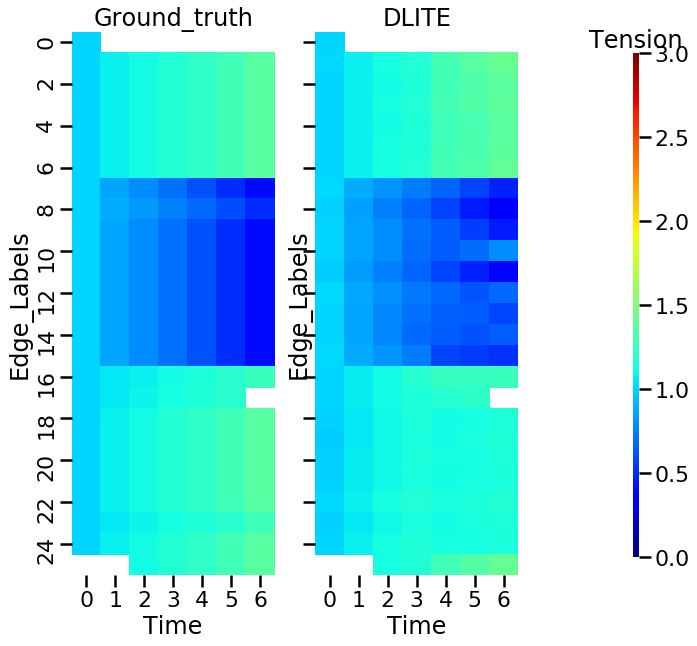

In [12]:
sns.set_context('poster')
fig, axn = plt.subplots(1, 2, figsize = (8,10),sharey=True)
cbar_ax = fig.add_axes([1.1, .15, .01, .7], title = 'Tension')

for i, ax in enumerate(axn.flat):
    if i == 0:
        df = ground_truth_tension_table
        title = 'Ground_truth'
    elif i == 1:
        df = tension_table
        title = 'DLITE'
    ax.set_title(title)
    sns.heatmap(df, ax=ax,
                cbar=i == 0, vmin=0, vmax=3, cmap = 'jet',
                cbar_ax=None if i else cbar_ax)

## Colony colormaps

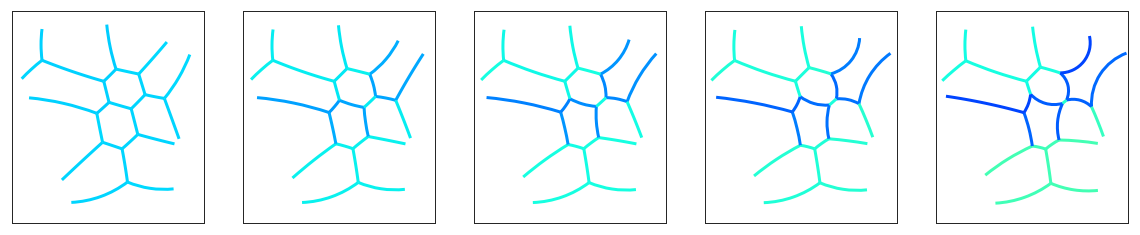

In [13]:
# Plot 
import pylab
import matplotlib.pyplot as plt


sns.set(style="white")
sns.set_context("paper", font_scale = 2.5)

total = 5
fig, axn = plt.subplots(1, total, figsize = (20,20),sharey=True)
nums= [0,1,2,3,4]

for i, ax in enumerate(axn.flat):
    col = colonies[str(nums[i])]
    tensions = [e.tension for e in col.tot_edges]
    mean_ten = np.mean(tensions)
    tensions = [e/mean_ten for e in tensions]

    col.plot_tensions(ax, fig, tensions, min_x=450, max_x=550, min_y=430, max_y=550, 
                      min_ten = 0, max_ten = 3, specify_color = 'jet',cbar = 'no', lw = 3)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set(xlim = [450,550], ylim = [430,540], aspect = 1)

# pylab.savefig('geometry.pdf', bbox_inches = 'tight')
# pylab.savefig('geometry.svg', bbox_inches = 'tight')

## Tension movies

In [15]:
sns.set(style="darkgrid")
sns.set_context("talk", font_scale=0.75)

fig, ax = plt.subplots(1,1, figsize = (6,4))
ManualTracingMultipleInstance.plot_tensions(fig, ax, colonies,min_x=450, max_x=550, min_y=430, max_y=550, 
                                            min_ten=0,max_ten=3, specify_aspect=None,specify_color='jet' ,
                                            type=None, lw = 2)